In [1]:
import scipy.io as spio
import numpy as np

In [2]:
X = spio.loadmat(file_name='../data/bci-sample-data/x.mat')

In [3]:
Y = spio.loadmat(file_name='../data/bci-sample-data/y.mat')

In [4]:
Data = X['Intensification_Data']
SType = Y['Intensification_SType'].mean(axis=1)

In [5]:
(Data.shape, SType.shape, Data.dtype, SType.dtype)

((6480, 192, 64), (6480,), dtype('<f8'), dtype('float64'))

In [6]:
# 30 % total data test
# 70 % total data train+valid
length = int(Data.shape[0] * 0.30)
length

1944

In [7]:
TrainDataAll = Data[:-length]
TestData = Data[-length:]

In [8]:
TrainDataAll.shape, TestData.shape

((4536, 192, 64), (1944, 192, 64))

In [9]:
# 30% total train data is valid
# 70% total trainALl is training
length2 = int(TrainDataAll.shape[0] * 0.30)
length2

1360

In [10]:
TrainData = TrainDataAll[:-length2]
ValidData = TrainDataAll[-length2:]

In [11]:
TrainData.shape, ValidData.shape

((3176, 192, 64), (1360, 192, 64))

In [12]:
# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [13]:
# Standardize/normalize train and test
X_train_norm = normalize(inputs=TrainData)
X_valid_norm = normalize(inputs=ValidData)
X_test_norm = normalize(inputs=TestData)

In [14]:
(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

((3176, 192, 64),
 dtype('<f8'),
 (1360, 192, 64),
 dtype('<f8'),
 (1944, 192, 64),
 dtype('<f8'))

In [15]:
LabelsAll = SType[:]
TrainLabelsAll = SType[:-length]
TestLabels = SType[-length:]

In [16]:
LabelsAll.shape, TrainLabelsAll.shape, TestLabels.shape

((6480,), (4536,), (1944,))

In [17]:
TrainLabels = TrainLabelsAll[:-length2]
ValidLabels = TrainLabelsAll[-length2:]

In [18]:
TrainLabels.shape, ValidLabels.shape

((3176,), (1360,))

In [19]:
Y_train = np.array(TrainLabels, dtype=int)
Y_valid = np.array(ValidLabels, dtype=int)
Y_test = np.array(TestLabels, dtype=int)

In [20]:
(Y_train.shape, Y_train.dtype, 
Y_test.shape, Y_test.dtype,
Y_valid.shape, Y_valid.dtype)

((3176,), dtype('int64'), (1944,), dtype('int64'), (1360,), dtype('int64'))

### Hyperparameters

In [21]:
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
n_classes = int(LabelsAll.max() + 1)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 1 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [22]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

In [23]:
(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape,
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

((3176, 2),
 (1360, 2),
 (1944, 2),
 (3176, 192, 64),
 (1360, 192, 64),
 (1944, 192, 64))

# GPUs availability or CPU

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [25]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers, FC Layer, and Output layer

In [26]:
# (batch, 192, 64) --> (batch, 94, 128)
# (192 - 6 + 0)/2 + 1 = (186/2)+1= 93+1= 94
# (2/6)==(1/3) with strides/kernel_size is 33.333% non-overlap/diff region and 
# 66.666% overlapping window/ common region
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=128, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 94, 128) --> (batch, 45, 256)
# (94 - 6 + 0)/2 + 1 = (88/2)+1= 44+1= 45
# (2/6)==(1/3) with strides/kernel_size is 33.333% non-overlap/diff region and 
# 66.666% overlapping window/ common region
in_conv = out_conv
out_conv = tf.layers.conv1d(inputs=in_conv, filters=256, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 45, 256) --> (batch, 45*256) --> (batch, 45*256*2)
# 45*256 = 50*64 - 1*64 = 3200 - 64 = 3136, 3136*2 = 6272
# (batch, 49, 64) --> (batch, 3136) --> (batch, 6272)
in_fc = tf.reshape(tensor=out_conv, shape=(-1, 49*64))
out_fc = tf.layers.dense(inputs=in_fc, units=49*64*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 49*64*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 91, 18)
(?, 1638) (?, 3276)
(?, 2)


In [27]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [29]:
# Plotting the acc and loss curve
train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
       
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_: keep_prob, learning_rate_:learning_rate}
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################################ Validation
            # Initialize 
            loss_v_batch, acc_v_batch = [], []

            # Loop over batches
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_:x_v, labels_:y_v, keep_prob_: 1.0}
                loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)
                
                acc_v_batch.append(acc_v)
                loss_v_batch.append(loss_v)
                
            valid_acc.append(np.mean(acc_v_batch))
            valid_loss.append(np.mean(loss_v_batch))
            
            # Print info
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(loss),
                  "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                  "Train acc: {:6f}".format(acc),
                  "Valid acc: {:.6f}".format(np.mean(valid_acc)))
            
    ################################ Test
    # Initialize 
    acc_batch, loss_batch = [], []

    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_:x, labels_:y, keep_prob_:1.0}
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)

        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:6f}".format(np.mean(acc_batch)))

Epoch: 1/1 Train loss: 2.645248 Valid loss: 2.747576 Train acc: 0.290323 Valid acc: 0.833458
Epoch: 1/1 Train loss: 5.820436 Valid loss: 3.324418 Train acc: 0.806452 Valid acc: 0.833458
Epoch: 1/1 Train loss: 5.537508 Valid loss: 3.691692 Train acc: 0.806452 Valid acc: 0.833458
Epoch: 1/1 Train loss: 3.012818 Valid loss: 3.918167 Train acc: 0.870968 Valid acc: 0.833458
Epoch: 1/1 Train loss: 4.399818 Valid loss: 4.010785 Train acc: 0.806452 Valid acc: 0.833458
Epoch: 1/1 Train loss: 1.418678 Valid loss: 4.040558 Train acc: 0.870968 Valid acc: 0.833458
Epoch: 1/1 Train loss: 2.091600 Valid loss: 3.965137 Train acc: 0.806452 Valid acc: 0.833351
Epoch: 1/1 Train loss: 1.491446 Valid loss: 3.839387 Train acc: 0.741935 Valid acc: 0.831583
Epoch: 1/1 Train loss: 1.709944 Valid loss: 3.677674 Train acc: 0.838710 Valid acc: 0.827040
Epoch: 1/1 Train loss: 3.229526 Valid loss: 3.484790 Train acc: 0.838710 Valid acc: 0.812603
Epoch: 1/1 Train loss: 1.200591 Valid loss: 3.561882 Train acc: 0.8709

Epoch: 1/1 Train loss: 0.803277 Valid loss: 1.155765 Train acc: 0.838710 Valid acc: 0.757186
Epoch: 1/1 Train loss: 0.667151 Valid loss: 1.148959 Train acc: 0.741935 Valid acc: 0.757958
Epoch: 1/1 Train loss: 0.564863 Valid loss: 1.142248 Train acc: 0.774194 Valid acc: 0.758698
Epoch: 1/1 Train loss: 0.338720 Valid loss: 1.135754 Train acc: 0.903226 Valid acc: 0.759445
Epoch: 1/1 Train loss: 0.483259 Valid loss: 1.129520 Train acc: 0.774194 Valid acc: 0.760185
Epoch: 1/1 Train loss: 0.310054 Valid loss: 1.123477 Train acc: 0.838710 Valid acc: 0.760925
Epoch: 1/1 Train loss: 0.448501 Valid loss: 1.117595 Train acc: 0.870968 Valid acc: 0.761649
Epoch: 1/1 Train loss: 0.892400 Valid loss: 1.111552 Train acc: 0.838710 Valid acc: 0.762344
Epoch: 1/1 Train loss: 0.574339 Valid loss: 1.105459 Train acc: 0.870968 Valid acc: 0.762948
Epoch: 1/1 Train loss: 0.507461 Valid loss: 1.099686 Train acc: 0.806452 Valid acc: 0.763293
Epoch: 1/1 Train loss: 0.496719 Valid loss: 1.094455 Train acc: 0.8064

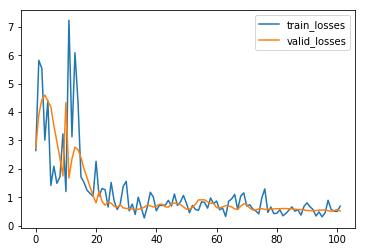

In [31]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

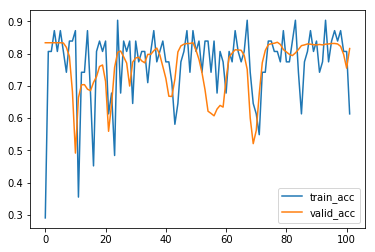

In [33]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()